In [34]:
import numpy as np
import pandas as pd
import torch
import zipfile
import bz2
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split

# Data

## 1. Twitter

In [4]:
data_path = "../data/"

In [105]:
twitter_zip = zipfile.ZipFile(data_path + "twitter/twitter.zip")
twitter = pd.read_csv(twitter_zip.open('training.1600000.processed.noemoticon.csv'),encoding='ISO-8859-1', header=None)
twitter.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [82]:
y_tw = twitter[0].values
y_tw[y_tw==4]=1
X_tw = twitter[5].values

X_train_val_tw, X_test_tw, y_train_val_tw, y_test_tw = train_test_split(X_tw, y_tw, test_size=0.33, random_state=7)
X_train_tw, X_dev_tw, y_train_tw, y_dev_tw = train_test_split(X_train_val_tw, y_train_val_tw, test_size=0.33, random_state=7)

## 2. Amazon

In [150]:
amazon_train_file = bz2.BZ2File(data_path + 'amazon/train.ft.txt.bz2').readlines()
amazon_test_file = bz2.BZ2File(data_path + 'amazon/test.ft.txt.bz2').readlines()

In [46]:
amazon_train_file = [x.decode('utf-8') for x in amazon_train_file]
amazon_test_file = [x.decode('utf-8') for x in amazon_test_file]

In [65]:
amazon_train_file[0].find(" ")
def get_label_feature_amazon(file):
    labels = []
    reviews = []
    for i, e in enumerate(file):
        sep_pos = e.find(" ")
        label = 1 if e[:sep_pos]=="__label__2" else 0
        review = e[(sep_pos+1):]
        labels.append(label)
        reviews.append(review)
    return reviews, labels

In [67]:
X_train_val_az, y_train_val_az = get_label_feature_amazon(amazon_train_file)
X_test_az, y_test_az = get_label_feature_amazon(amazon_train_file)
X_train_az, X_dev_az, y_train_az, y_dev_az = train_test_split(X_train_val_az, y_train_val_az, test_size=0.33, random_state=7)

In [96]:
sum(y_train_az[:2000])/len(y_train_az[:2000])

0.5095

## 3. Movie

In [121]:
movie_zip = zipfile.ZipFile(data_path + "movies/movie.zip")

In [127]:
movie_train = pd.read_csv(movie_zip.open('Train.csv'))
movie_dev = pd.read_csv(movie_zip.open('Valid.csv'))
movie_test = pd.read_csv(movie_zip.open('Test.csv'))

In [132]:
X_train_mv = movie_train['text'].values
X_dev_mv = movie_dev['text'].values
X_test_mv = movie_test['text'].values

y_train_mv = movie_train['label'].values
y_dev_mv = movie_dev['label'].values
y_test_mv = movie_test['label'].values

In [133]:
X_train_mv[0], y_train_mv[0]

('I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.',
 0)

## 4. Finance

In [157]:
finance_file = pd.read_csv(data_path + "/finance/archive/all-data.csv", encoding='ISO-8859-1', header = None)

In [160]:
finance =  finance_file[finance_file[0]!="neutral"]

In [197]:
y_fi = finance[0].values
y_fi[y_fi=="negative"] = 0
y_fi[y_fi=="positive"] = 1
y_fi = y_fi.astype("int64")
X_fi = finance[1].values

X_train_val_fi, X_test_fi, y_train_val_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=0.33, random_state=7)
X_train_fi, X_dev_fi, y_train_fi, y_dev_fi = train_test_split(X_train_val_fi, y_train_val_fi, test_size=0.33, random_state=7)

# Encode

In [7]:
tokenizer_d = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_d = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [9]:
list(X_train)[:10]

['@Jayme1988 well when you are younger Id agree but as we get older..marrying for money is the way to go ',
 '@Jackalltimelow Awee poor Jack, all alllone! ',
 'my tummy hurts. ',
 'mmmmm pa says my room has to be blue once again  ',
 '@xsameehx wish you were here my love. Our superhero trio is not the same as a duo only ',
 'Watched War of the Worlds. Not bad. Kept seeing Kathy Bates tits flash in my head. ',
 'Just had a really lovely conversation on omegle  I think i made a new friend',
 "@tommcfly tom, isn't your fault, you're still the best ",
 '@catnip070 Caught a cold  cough cough.',
 "@blacksocialite I think we staying at slice... I showed 255 my real I'd "]

In [209]:
# def tokenize_sentences(tokenizer, input_sentences, output_path):
#     encoded_input = tokenizer(input_sentences, return_tensors = 'pt', truncation = True, padding = True)
#     torch.save(encoded_input, output_path)
#     return encoded_input

# def encode_sentences(tokenizer, model, input_sentences, tokenize_path, output_path, batch_size):
#     output = np.zeros([len(input_sentences), 768])
#     encoded_input = torch.load(tokenize_path)
#     with torch.no_grad():
#         for i in range(int(len(X_train)/batch_size)):
#             encoded_input_batch = {}
#             encoded_input_batch['input_ids'] = encoded_input['input_ids'][i*batch_size: min(len(input_sentences), (i+1)*batch_size)]
#             encoded_input_batch['attention_mask'] = encoded_input['attention_mask'][i*batch_size: min(len(input_sentences), (i+1)*batch_size)]
#             output[i*batch_size: min(len(input_sentences),(i+1)*batch_size)] = model_d(**encoded_input_batch)[0][:,0,:].numpy()
#     np.save(output_path, output)
#     return output

# def tokenize_encode_sentences(tokenizer, model, input_sentences, output_path):
#     output = np.zeros([len(input_sentences), 768])
#     for i, x in enumerate(input_sentences): 
#         encoded_input = tokenizer([x], return_tensors = 'pt', truncation = True, padding = True)
#         output[i] = model_d(**encoded_input)[0][:,0,:].detach().numpy()
#     np.save(output_path, output)
#     return output

def tokenize_encode_sentences(tokenizer, model, input_sentences, output_path):
    output = np.zeros([len(input_sentences), 768])
    for i, x in enumerate(input_sentences): 
        output[i] = tokenize_encode_sentences_sample(tokenizer, model, [x])
    np.save(output_path, output)
    return output

def tokenize_encode_sentences_sample(tokenizer, model, input_sentences):
    encoded_input = tokenizer(input_sentences, return_tensors = 'pt', truncation = True, padding = True)
    output = model(**encoded_input)[0][:,0,:].detach().numpy()
    return output

In [167]:
output_train_tw = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_tw[:2000]), "../outputs/" + "encoded_twitter_train_2000")
output_dev_tw = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_tw[:2000]), "../outputs/" + "encoded_twitter_dev_2000")

In [168]:
output_train_az = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_az[:2000]), "../outputs/" + "encoded_amazon_train_2000")
output_dev_az = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_az[:2000]), "../outputs/" + "encoded_amazon_dev_2000")

In [169]:
output_train_mv = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_mv[:2000]), "../outputs/" + "encoded_movie_train_2000")
output_dev_mv = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_mv[:2000]), "../outputs/" + "encoded_movie_dev_2000")

In [166]:
output_train_fi = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_fi[:2000]), "../outputs/" + "encoded_finance_train_2000")
output_dev_fi = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_fi[:2000]), "../outputs/" + "encoded_finance_dev_2000")

# Models

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

lr = LogisticRegression(C=0.1, max_iter = 200000)

datasets = ["tw", "az", "mv", "fi"]

def results(model, datasets):
    for s in datasets:
        print(s)
        model.fit(eval("output_train_" + s), eval("y_train_" + s)[:2000])
        s_train = model.score(eval("output_train_" + s), eval("y_train_" + s)[:2000])
        s_val = model.score(eval("output_dev_" + s), eval("y_dev_" + s)[:2000])
        print("source train:", s_train)
        print("source val:", s_val)
        datasets_ts = datasets.copy()
        datasets_ts.remove(s)
        
        for t in datasets_ts:
            t_val = model.score(eval("output_train_" + t), eval("y_train_" + t)[:2000])
            print("target " + t + ":", t_val)
        print()

In [208]:
results(lr, datasets)

tw
source train: 0.8
source val: 0.751
target az: 0.8065
target mv: 0.758
target fi: 0.7721088435374149

az
source train: 0.9015
source val: 0.884
target tw: 0.721
target mv: 0.8185
target fi: 0.8015873015873016

mv
source train: 0.87
source val: 0.8575
target tw: 0.7005
target az: 0.8535
target fi: 0.8344671201814059

fi
source train: 0.8820861678004536
source val: 0.8344827586206897
target tw: 0.711
target az: 0.7675
target mv: 0.7535



# Conclusion:
We can use: 
* tw --> fi
* az --> mv
* az --> fi
* mv --> az
* fi --> az (low priority, bc rarely finance is the source in real world)
* fi --> mv (low priority, bc rarely finance is the source in real world)

# Source to target groups

In [243]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [260]:
az_bert = np.mean(output_train_az,0)
dists = []
for e in output_train_mv:
    dist = cosine_similarity(az_bert.reshape(1, -1), e.reshape(1, -1))[0][0]
    dists.append(dist)

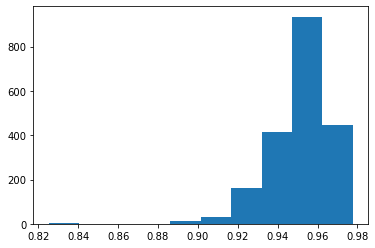

In [263]:
plt.hist(dists)
plt.show()

In [279]:
dists = np.array(dists)

In [275]:
dists[892]

0.977732396772905

In [276]:
dists_order = np.argsort(dists)
dists_rank = np.argsort(dists_order)

In [278]:
dists_rank[892]

1999